In [414]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.tree import plot_tree, export_text
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, mean_squared_error, recall_score, precision_score

In [415]:
modeling_df = pd.read_csv('./Data/modeling_df.csv', index_col=False)

In [416]:
modeling_df.sample(5)

,title,author,subreddit,is_xx
2936,Why do women believe in astrology?,Throaway0913,AskWomen,1
4799,Men of Reddit would you seriously date an 0F g...,JonAHogan,AskMen,0
3739,Approaching a man at the gym,throwaway1234zzzzia,AskMen,0
2506,What to do on first dates?,Mindless_Scarcity389,AskWomen,1
1808,How likely is it that most women believe Johnn...,seacobs,AskWomen,1


# Preprocessing

### Define X and y:

In [417]:
X = modeling_df['title']
y = modeling_df['is_xx']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

### Find the baseline score:

In [418]:
y.value_counts(normalize=True).round(2)

1    0.52
0    0.48
Name: is_xx, dtype: float64

- 52% of the posts are from AskWomen subreddit and 48% are from AskMen subreddit.

### Using CountVectorize:

##### CountVectorize(stop_word='english', ngrams=default)

In [419]:
cv = CountVectorizer(stop_words='english')
cv.fit(X_train)
X_train_cv = cv.transform(X_train).A
X_test_cv = cv.transform(X_test).A

In [420]:
X_train_cv = pd.DataFrame(X_train_cv, columns=cv.get_feature_names_out())
X_test_cv = pd.DataFrame(X_test_cv, columns=cv.get_feature_names_out())

In [421]:
X_train_cv.head()

,000,0f,10,100,1000s,100k,100s,11,117lb,12,...,yt,yu,zaddy,zero,zones,zoom,¼ð,ᕼoᗯ,ᗪᗩy,ᗯᗩտ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [422]:
X_test_cv.sum().sort_values(ascending=False)[:20]

men             178
women           167
like             93
did              90
feel             79
woman            69
think            62
guy              60
girl             59
partner          59
sex              59
does             57
man              56
reddit           55
relationship     50
time             45
guys             44
dating           43
just             40
best             40
dtype: int64

##### CountVectorize(stop_word=None, ngrams=(1,2))

In [423]:
cv2 = CountVectorizer(ngram_range=(1,2))
cv2.fit(X_train)
X_train_cv2 = cv2.transform(X_train).A
X_test_cv2 = cv2.transform(X_test).A

In [424]:
X_train_cv2 = pd.DataFrame(X_train_cv2, columns=cv2.get_feature_names_out())
X_test_cv2 = pd.DataFrame(X_test_cv2, columns=cv2.get_feature_names_out())

In [425]:
X_test_cv.sum().sort_values(ascending=False)[:20]

men             178
women           167
like             93
did              90
feel             79
woman            69
think            62
guy              60
girl             59
partner          59
sex              59
does             57
man              56
reddit           55
relationship     50
time             45
guys             44
dating           43
just             40
best             40
dtype: int64

### Important features by subreddit

In [440]:
# AskWomen subreddit

# Redefine X and y and resplit data
X = modeling_df.loc[modeling_df['is_xx']==1, 'title']
y = modeling_df.loc[modeling_df['is_xx']==1, 'is_xx']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Parameters: CV, stop_words='english', max_features=200, ngram_range=(1,2)
cv = CountVectorizer(stop_words='english', max_features=200, ngram_range=(1,2))
cv.fit(X_train)
X_train = cv.transform(X_train)

X_train_df = pd.DataFrame(X_train.toarray(),
                          columns=cv.get_feature_names())

In [441]:
X_train_df.sum().sort_values(ascending=False).head(20)

women           378
feel            181
like            162
did             153
men             124
think           107
does            102
guy             100
partner          87
relationship     87
reddit           86
ladies           85
man              84
woman            82
make             68
know             67
sex              67
girl             63
life             63
don              62
dtype: int64

# Modeling and Model Evaluation

### Logistic Regression Model

In [226]:
lr = LogisticRegression(max_iter=10_000)

lr.fit(X_train_cv, y_train)

LogisticRegression(max_iter=10000)

In [336]:
lr.score(X_train_cv, y_train).round(2), lr.score(X_test_cv, y_test).round(2)

(0.89, 0.65)

In [341]:
#Save the score for later comparison:
lr_cv = lr.score(X_test_cv, y_test).round(2)
lr_cv

0.65

The logistic regressin model predicts better than the baseline, but it is overfitting.

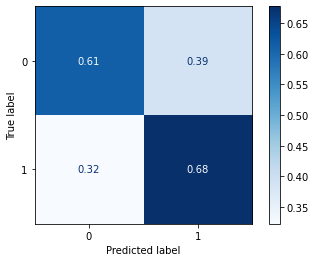

In [233]:
ConfusionMatrixDisplay.from_estimator(lr,X_test_cv,y_test, cmap='Blues', normalize='true')

In [240]:
preds = lr.predict(X_test_cv)

In [245]:
#calculate recall/sensitivity:
recall_score(y_test, preds)

0.677027027027027

In [246]:
#calculate precision score:
precision_score(y_test, preds)

0.6498054474708171

In [260]:
#calculate mean square error
mean_squared_error(y_test, preds)

0.3544568245125348

### Random Forest Model

In [248]:
rfc = RandomForestClassifier()
etc = ExtraTreesClassifier()

In [251]:
rfc_scores = cross_val_score(rfc, X_train_cv, y_train)
print(rfc_scores)
print(rfc_scores.mean())

[0.66357309 0.63225058 0.6387921  0.65389082 0.65272938]
0.6482471954318482


In [340]:
#Save the score for later comparison:
rfc_cv = rfc_scores.mean().round(2)
rfc_cv

0.65

The random tree model's score did similarly to the logistic regression.

#### Try grid search

In [253]:
grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 5, 7, 10, 12, 15],
    'min_samples_split': [2, 3, 5]
}

gs = GridSearchCV(rfc, param_grid=grid, n_jobs=-1)
gs.fit(X_train_cv, y_train)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 7, 10, 12, 15],
                         'min_samples_split': [2, 3, 5],
                         'n_estimators': [100, 150, 200]})

In [254]:
gs.best_score_, gs.best_estimator_

(0.6556785262913949,
 RandomForestClassifier(min_samples_split=5, n_estimators=200))

In [339]:
#Save the score for later comparison:
rfc_gs_cv = gs.best_score_.round(2)
rfc_gs_cv

0.66

In [258]:
tree_preds = gs.best_estimator_.predict(X_test_cv)
mean_squared_error(y_test, tree_preds)

0.3467966573816156

### KNN Model

In [262]:
ss = StandardScaler()

ss.fit(X_train_cv)
X_train_scaled = ss.transform(X_train_cv)
X_test_scaled = ss.transform(X_test_cv)

knn = KNeighborsClassifier()

knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [343]:
#Save the score for later comparison:
knn.score(X_train_scaled, y_train), knn.score(X_test_scaled, y_test)


(0.7302066403529138, 0.5724233983286908)

In [345]:
#Save the score for later comparison:
knn_cv = knn.score(X_test_scaled, y_test).round(2)
knn_cv

0.57

In [263]:
knn_preds = knn.predict(X_test_scaled)

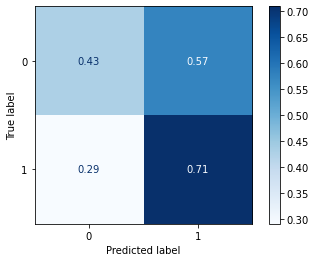

In [266]:
ConfusionMatrixDisplay.from_estimator(knn, X_test_scaled, y_test, cmap='Blues', normalize='true')

In [267]:
mean_squared_error(y_test, knn_preds)

0.4275766016713092

In [268]:
#calculate recall/sensitivity:
recall_score(y_test, preds)

0.677027027027027

In [269]:
#calculate precision:
precision_score(y_test, preds)

0.6498054474708171

### Voting Classifier

In [270]:
vc = VotingClassifier(
    [
        ('lr', LogisticRegression()),
        ('knn', KNeighborsClassifier(n_neighbors=12, weights='distance')),
        ('rfc', RandomForestClassifier(n_estimators=200))
    ],
    n_jobs=-1,
)

In [271]:
vc.fit(X_train_scaled, y_train)
vc_preds = vc.predict(X_test_scaled)
mean_squared_error(y_test, vc_preds)

0.3635097493036212

In [279]:
#Accuracy score:
vc.score(X_train_scaled, y_train), vc.score(X_test_scaled, y_test)

(0.990016252612027, 0.6364902506963789)

In [346]:
#Save the score for later comparison:
vc_cv = vc.score(X_test_scaled, y_test).round(2)

The vc model is overfitting. Although the accuracy score is higher than the baseline, it is still pretty low.

#### Pipeline: CountVectorizer, Logistic Rgression

In [272]:
pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('lr', LogisticRegression(max_iter=10_000, n_jobs=-1, random_state=123))
])

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.909914093336429, 0.7054317548746518)

Grid search:

In [275]:
grid2 = {
    "cv__min_df": [3,2,1],
    "cv__stop_words": [None,'english'],
    'cv__ngram_range': [(1,2), (1,3)],
    
}
gs2 = GridSearchCV(pipe, param_grid=grid2, n_jobs=-1)
gs2.fit(X_train, y_train)
gs2.score(X_train, y_train), gs2.score(X_test, y_test)

(0.9911771534710936, 0.7284122562674095)

In [276]:
gs2.best_params_

{'cv__min_df': 1, 'cv__ngram_range': (1, 2), 'cv__stop_words': None}

Conducting pipeline with count vectorizer resulted the best score so far. 
<br>
Adding grid search indicates that the best results so far are acieved when:
<br>
    - The model ignores terms that appear in less than 1% of the documents ('cv__min_df': 1)
<br>
    - Using both  unigrams and bigrams ('cv__ngram_range': (1, 2))
<br>
    - Using defaul stop words ('cv__stop_words': None)

In [347]:
#Save the score for later comparison:
cv_lr_gs = gs2.score(X_test, y_test).round(2)

### Compare TfidfVectorizer to CountVectorizer

Try to improve the results by using TfidfVectorizer instead of CountVectorizer:

In [280]:
pipe2 = Pipeline([
    ('tf', TfidfVectorizer(min_df=1, stop_words='english')),
    ('lr', LogisticRegression())
])

pipe2.fit(X_train, y_train)
pipe2.score(X_train, y_train), pipe2.score(X_test, y_test)

(0.8558161133039238, 0.6448467966573816)

In [283]:
grid3 = {
    "cv__min_df": [3,2,1],
    "cv__stop_words": [None,'english'],
    'cv__ngram_range': [(1,2), (1,3)],
    
}
gs3 = GridSearchCV(pipe, param_grid=grid3, n_jobs=-1)
gs3.fit(X_train, y_train)
gs3.score(X_train, y_train), gs3.score(X_test, y_test)

(0.9911771534710936, 0.7284122562674095)

TfidfVectorizer scores are similar to CountVectorizer scores.

In [349]:
#Save the score for later comparison:
tfidf_lr_gs = gs3.score(X_test, y_test).round(2)

In [ ]:
### List of 

In [298]:
cv2 = CountVectorizer(stop_words=None, ngram_range=(1,2))

In [299]:
cv2.fit(X_train)
X_train_cv2 = cv2.transform(X_train).A
X_test_cv2 = cv2.transform(X_test).A

In [301]:
X_train_cv2 = pd.DataFrame(X_train_cv2, columns=cv2.get_feature_names_out())
X_test_cv2 = pd.DataFrame(X_test_cv2, columns=cv2.get_feature_names_out())

In [302]:
X_test_cv2.sum().sort_values(ascending=False)[:20]

you       879
what      562
do        469
to        453
how       389
your      351
the       345
is        282
and       264
of        242
it        233
in        226
do you    225
for       195
with      194
that      187
men       178
women     167
why       166
on        154
dtype: int64

# Comparing Models Performances

In [354]:
y.value_counts(normalize=True).round(2)

1    0.52
0    0.48
Name: is_xx, dtype: float64

In [355]:
baseline_score = 0.52

In [356]:
# Generate a dataframe of model & accuracy score
list_of_models = [lr_cv, cv_lr_gs,
                  rfc_cv, rfc_gs_cv, 
                  knn_cv, tfidf_lr_gs,
                  baseline_score]

In [357]:
list_of_models

[0.65, 0.73, 0.65, 0.66, 0.57, 0.73, 0.52]

In [395]:
accuracy_scores_df = pd.DataFrame(np.array(list_of_models),columns=['accuracy_score'], index = ['lr_cv', 'cv_lr_gs',
                  'rfc_cv', 'rfc_gs_cv', 
                  'knn_cv', 'tfidf_lr_gs',
                  'baseline_score'])
accuracy_scores_df

,accuracy_score
lr_cv,0.65
cv_lr_gs,0.73
rfc_cv,0.65
rfc_gs_cv,0.66
knn_cv,0.57
tfidf_lr_gs,0.73
baseline_score,0.52


In [396]:
accuracy_scores_df = accuracy_scores_df.sort_values('accuracy_score')
accuracy_scores_df

,accuracy_score
baseline_score,0.52
knn_cv,0.57
lr_cv,0.65
rfc_cv,0.65
rfc_gs_cv,0.66
cv_lr_gs,0.73
tfidf_lr_gs,0.73


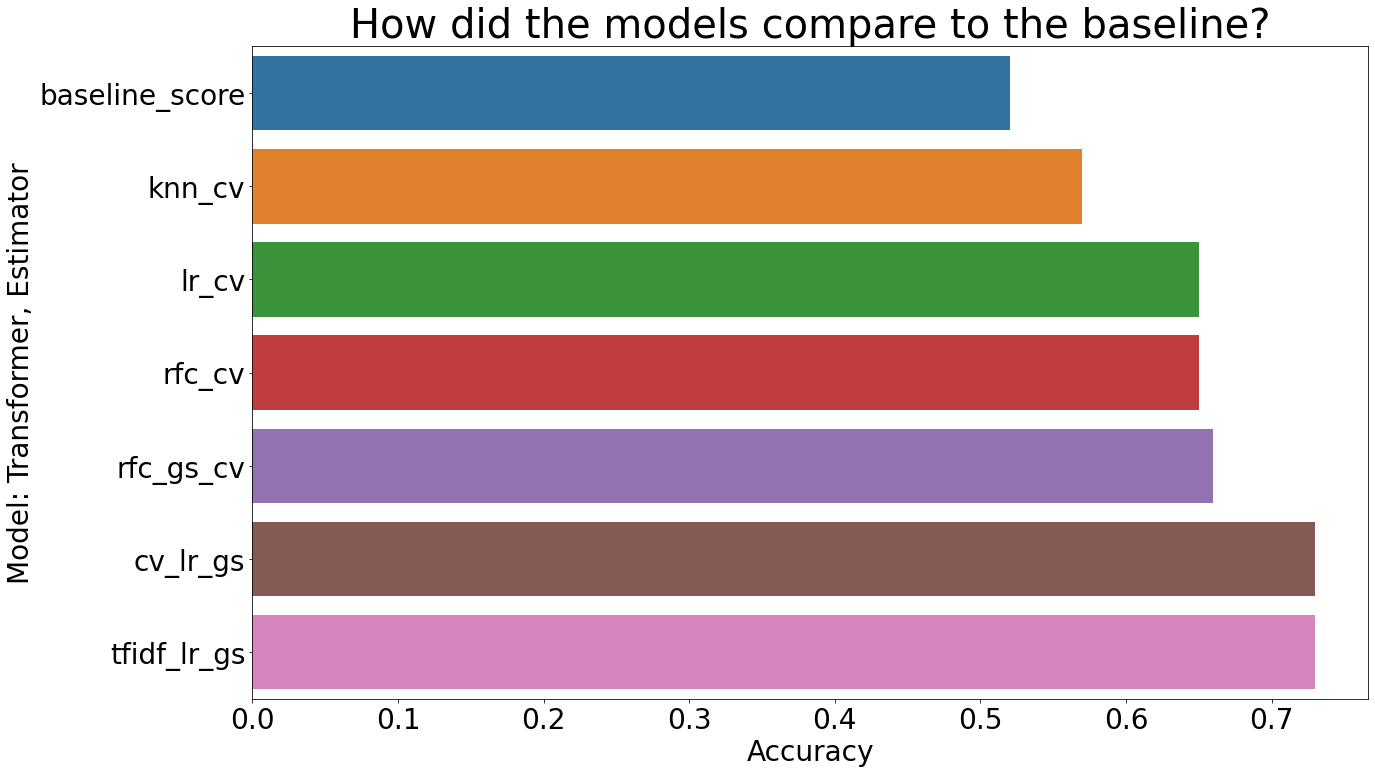

In [400]:
plt.figure(figsize=(20,12))
sns.barplot(data=models_df, x=accuracy_scores_df['accuracy_score'], y=accuracy_scores_df.index )
plt.xlabel('Accuracy', size=28)
plt.ylabel('Model: Transformer, Estimator', size=28)
plt.yticks(size=28)
plt.xticks(size=28)
plt.title('How did the models compare to the baseline?', size=40)
plt.savefig('./Figures/models_compared_to_the_baseline.png')